In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as image

from pprint import pprint

%matplotlib inline

In [3]:
# below variables are established to be used throughout the notebook without being subjected to any change
BATCH_SIZE     = 64
HEIGHT = WIDTH = 48
CHANNELS       =  3

EMOTIONS       = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

C:\Users\KARAN\Desktop\Cambridge\data\FER2013

In [4]:
import os
import re

import numpy as np
import pandas as pd

import cv2
import PIL.Image as Image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from torchvision import transforms

# Preprocessing (skip)

In [5]:
paths   = []
labels  = []

base = f"C:\\Users\\KARAN\\Desktop\\Cambridge\\data\\FER2013\\"

if os.path.exists(path=base) and os.path.isdir(base):
    
    for level_1_dir in os.listdir(path=base): 
        level_1_path = f"{level_1_dir}"
        if os.path.exists(path=base + level_1_path):
            for level_2_dir in os.listdir(path=base + level_1_path): # 7 emotions
                level_2_path =f"{level_1_path}/{level_2_dir}"
                if os.path.exists(path=base + level_2_path) and os.path.isdir(base + level_2_path):
                    for file in os.listdir(path=base + level_2_path): # files
                        file_path = f"{level_2_path}/{file}"
                        if os.path.isfile(base + file_path):
                            paths.append(file_path)
                            labels.append(level_2_dir)

df = pd.DataFrame({'path': [base + path for path in paths], 'label': labels})

In [6]:
# create a new column to store the images as ndarray
df['img_as_matrix'] = df['path'].apply(lambda path: cv2.imread(path))

# view firts 5 rows of the newly created dataframe
df.head()

,path,label,img_as_matrix
0,C:\Users\KARAN\Desktop\Cambridge\data\FER2013\...,angry,"[[[46, 46, 46], [34, 34, 34], [26, 26, 26], [2..."
1,C:\Users\KARAN\Desktop\Cambridge\data\FER2013\...,angry,"[[[55, 55, 55], [33, 33, 33], [54, 54, 54], [3..."
2,C:\Users\KARAN\Desktop\Cambridge\data\FER2013\...,angry,"[[[123, 123, 123], [123, 123, 123], [126, 126,..."
3,C:\Users\KARAN\Desktop\Cambridge\data\FER2013\...,angry,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,C:\Users\KARAN\Desktop\Cambridge\data\FER2013\...,angry,"[[[127, 127, 127], [121, 121, 121], [124, 124,..."


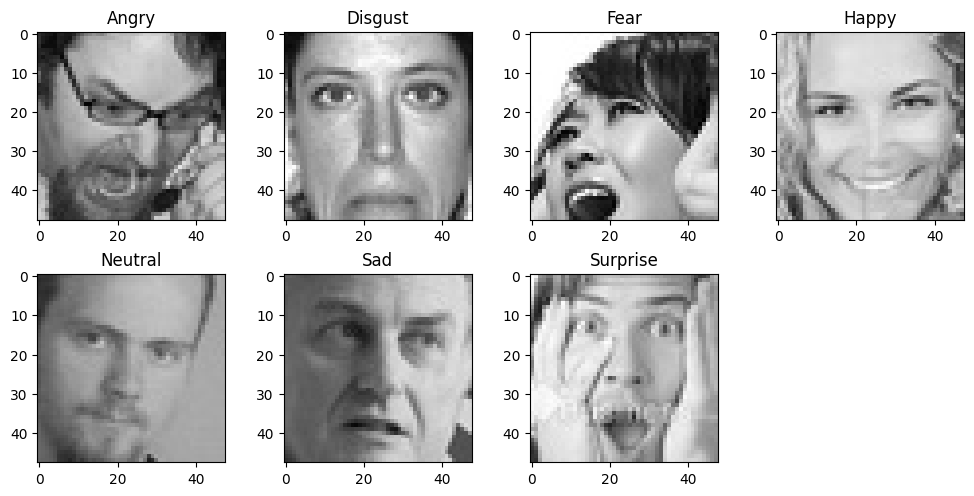

In [7]:
# set plotting options
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

for index, label in enumerate(df['label'].unique()):
    img = df[df['label'] == label]['img_as_matrix'].iloc[0]
    
    exec(f"ax{index + 1}.imshow(img)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

<BarContainer object of 7 artists>

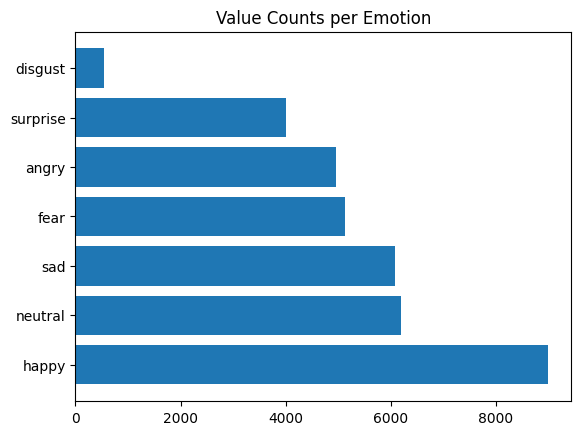

In [8]:
plt.title('Value Counts per Emotion')
plt.barh(y = df.label.value_counts().index, width = df.label.value_counts().values)

Processing Data / Missing values and dropping Imgs far off the Mean err

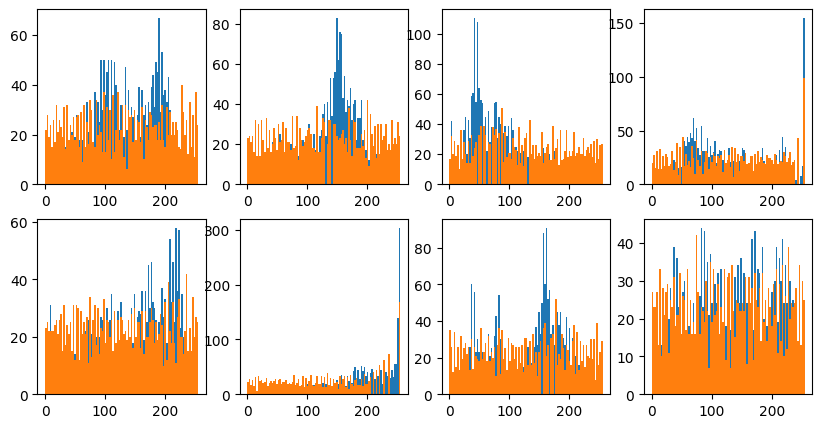

In [9]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(10, 5))

for index, img in enumerate(df['img_as_matrix']):
    # calculate mean value from RGB channels and flatten to 1D array
    img_1_chan = img.mean(axis=2).flatten().astype(np.uint8)
    
    # gett same 
    equ = cv2.equalizeHist(img_1_chan)
    
    exec(f"ax{index + 1}.hist(img_1_chan, bins=100, range=(0, 255))")
    exec(f"ax{index + 1}.hist(equ, bins=100, range=(0, 255))")
    
    if index >= 7:
        break

In [10]:
# store the average image per emotion
average_image_per_label = {}

# compute the average image per label
for index, label in enumerate(df['label'].unique()):
    avg_img = np.stack(df[df['label'] == label]['img_as_matrix']).mean(axis=0).astype(np.int8)
    
    # store the result
    average_image_per_label[label] = avg_img

In [11]:
# store deltas between each image and its label's average
deltas = []

for i in range(len(df)):
    label = df.loc[i, 'label']
    # find the delta between each image and its label's average
    delta = np.absolute(average_image_per_label[label] - df.loc[i, 'img_as_matrix'].astype(np.int8))
    deltas.append(delta)
    
df['delta_vs_avg_image'] = deltas

In [12]:
# find the mean error across all channels
df['mean_error'] = df['delta_vs_avg_image'].apply(lambda x: x.mean())

In [13]:
# find an average mean error per group
mean_errors_per_label = df.groupby('label')['mean_error'].mean()

# store standard deviations
error_stds = []

for i in range(len(df)):
    label = df.loc[i, 'label']
    # compute variance between mean error of each image and average error for label
    var = abs(df.loc[i, 'mean_error'] - mean_errors_per_label[label])**2
    # compute standard deviation from variance
    std = np.sqrt(var)
    # store the result
    error_stds.append(std)
    
df['error_std'] = error_stds

In [14]:
# compute standard deviation boundaries
min_std = df['error_std'].min()
max_std = df['error_std'].max()


# treat the image as anomalous if its mean error is below or above standard deviation boundaries.
def get_anomalous_point(mean_error: float, min_std: float, max_std: float): return mean_error < min_std or mean_error > max_std
    
# mark images as anomalous or not
df['check_for_anomalies'] = df['mean_error'].apply(lambda err: get_anomalous_point(err, min_std, max_std))

In [15]:
# retrieve indices of the anomalous images to drop
image_indices_to_drop = list(df[df['check_for_anomalies'] == True].index)

# drop anomalous image indices,reset index, and update dataframe
df = df.drop(image_indices_to_drop).reset_index(drop=True)

In [16]:
# print planned to be dropped indices
print(f"How many images gets dropped: {len(image_indices_to_drop)}\nSome samples: {image_indices_to_drop[:20]}\n")


How many images gets dropped: 9143
Some samples: [4, 5, 13, 14, 16, 20, 25, 30, 31, 35, 36, 38, 44, 45, 46, 47, 49, 51, 53, 54]



In [17]:
# view total number of records in dataset
print(f'Length of original dataset is: {len(df)}')

# decrease the dataset to %N samples per each category to solve the memory allocation issue
N_percent       = 0.3

# aggregating storage dataframe
df_agg          = pd.DataFrame(data=[], columns=df.columns)

# per each label, select the first %N samples and append to the aggregating dataframe
for lbl in np.unique(labels):
    len_to_keep = int(N_percent*len(df[df.label == lbl]))
    subset_df   = df[df.label == lbl][:len_to_keep]
    df_agg      = pd.concat([df_agg, subset_df])

# reset index and drop the resulting index column
df_agg          = df_agg.reset_index().drop('index', axis=1)

# view total number of records in the reduced dataset
print(f'Length of reduced dataset is: {len(df_agg)}')

Length of original dataset is: 26744
Length of reduced dataset is: 8020


C:\Users\KARAN\AppData\Local\Temp\ipykernel_25576\3191225578.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_agg      = pd.concat([df_agg, subset_df])


SMOTE for class imb

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=62)

# assign labels to y
y = df_agg['label']

# X is a list of read-in images
X = np.stack(df_agg['img_as_matrix'])

# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X.shape[index] for index in range(4)]

print(f"Shape of X before reshape: {X.shape}")

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_reshaped = X.reshape(n_samples, n_channels*height*width)

print(f"Shape of X before reshape: {X.shape}")

Shape of X before reshape: (8020, 48, 48, 3)
Shape of X before reshape: (8020, 48, 48, 3)


In [19]:
# perform re-sampling on modified X given y
X_smote, y_smote = smote.fit_resample(X_reshaped, y)

In [20]:
X_smote

array([[ 46,  46,  46, ..., 189, 189, 189],
       [ 55,  55,  55, ..., 187, 187, 187],
       [123, 123, 123, ...,   3,   3,   3],
       ...,
       [  1,   1,   1, ..., 174, 174, 174],
       [107, 107, 107, ..., 234, 234, 234],
       [ 66,  66,  66, ...,  77,  77,  77]], dtype=uint8)

In [21]:
# Assuming you have a NumPy array or PyTorch tensor named 'my_tensor'
# Save it to a file using NumPy
np.save('X_smote.npy', X_smote)
np.save('y_smote.npy', y_smote)



# Saved data load and use

In [22]:
# To load the tensor back
loaded_tensor = np.load('X_smote.npy')

In [23]:
print(f'Before re-sampling, the amount of images:  {len(X):6}')
print(f'After re-sampling, the amount of images:{len(X_smote):10}')

Before re-sampling, the amount of images:    8020
After re-sampling, the amount of images:     14742


<BarContainer object of 7 artists>

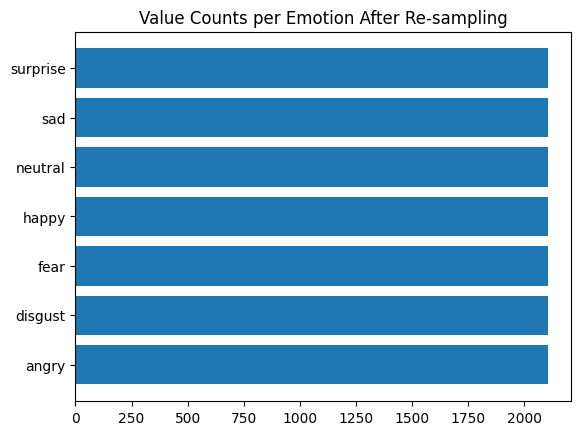

In [24]:
# view the resulting balanced data(modified distribution)
plt.title('Value Counts per Emotion After Re-sampling')
plt.barh(y = y_smote.value_counts().index, width = y_smote.value_counts().values)

In [25]:
# initializing label encoder
label_encoder = preprocessing.LabelEncoder()

# convert X and y to Tensors
X_smote = torch.Tensor(X_smote) # features
y_smote = label_encoder.fit_transform(y_smote) # targets
targets = torch.as_tensor(y_smote)

# split data into train, valid and test
X_train, X_trial, y_train, y_trial = train_test_split(X_smote, targets, test_size=0.20, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [26]:
X_train, X_trial, y_train, y_trial = X_train.to(device), X_trial.to(device), y_train.to(device), y_trial.to(device)
#X_valid, y_valid = X_valid.to(device), y_valid.to(device)

In [27]:
X_train.is_cuda

True

In [30]:
# print initial shape of the datasets
print(f"Initial shape of the X datasets along with y:\n\
    {X_train.shape}, {y_train.shape}\n\
    {X_trial.shape}, {y_trial.shape}\n")

# reshape to remove the requirements of SMOTE that do not suit standard model training
X_train = X_train.reshape((X_train.shape[0], 3, HEIGHT, WIDTH))
X_trial = X_trial.reshape((X_trial.shape[0], 3, HEIGHT, WIDTH))

# print latest shape of the datasets
print(f"Latest shape of the X datasets along with y:\n\
    {X_train.shape}, {y_train.shape}\n\
    {X_trial.shape}, {y_trial.shape}\n")

Initial shape of the X datasets along with y:
    torch.Size([11793, 3, 48, 48]), torch.Size([11793])
    torch.Size([2949, 6912]), torch.Size([2949])

Latest shape of the X datasets along with y:
    torch.Size([11793, 3, 48, 48]), torch.Size([11793])
    torch.Size([2949, 3, 48, 48]), torch.Size([2949])



In [ ]:
# create train, test and validation datasets for the data loader
train_ds = TensorDataset(X_train,y_train)
#valid_ds = TensorDataset(X_valid,y_valid)
trial_ds = TensorDataset(X_trial,y_trial)

In [ ]:
# add data transformations: (1) convert to tensor format, and (2) normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=180),
])

# apply transformations to the train set
train_ds.transform = transform

# apply transformations to the validation set
#valid_ds.transform = transform

# apply transformations to the test set
trial_ds.transform = transform

# create a dataloader for each subset of data
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
#validloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
trialloader = DataLoader(trial_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Train

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.model_selection import GridSearchCV
import torch.utils.data as data
import numpy as np

In [ ]:
import torch.nn as nn

class smallCNN(nn.Module):
    def __init__(self, num_classes):
        super(smallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(16 * 24 * 24, 128)  # Adjusted the input size to match 3x48x48 input
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.bn2(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x



In [ ]:
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 7)


    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.bn3(self.conv3(x))
        x = self.dropout2(x)
        x = self.bn4(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.bn5(self.fc1(x))
        x = self.dropout4(x)
        x = self.bn6(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)
        return x


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

4219

In [ ]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Define your model
num_classes = 7  # Number of classes in your dataset

model = smallCNN(num_classes)
model.to(device)

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create data loaders
# create train, test and validation datasets for the data loader
train_ds = TensorDataset(X_train,y_train)
valid_ds = TensorDataset(X_valid,y_valid)
trial_ds = TensorDataset(X_trial,y_trial)

# add data transformations: (1) convert to tensor format, and (2) normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=180),
])

# apply transformations to the train set
train_ds.transform = transform

# apply transformations to the validation set
valid_ds.transform = transform

# apply transformations to the test set
trial_ds.transform = transform

# create a dataloader for each subset of data
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
validloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
trialloader = DataLoader(trial_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
# # Training loop
# for epoch in range(NUM_EPOCHS):
#     # Training
#     model.train()
#     for data, labels in trainloader:
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, labels.long())
#         loss.backward()
#         optimizer.step()

#     # Validation
#     model.eval()
#     total_correct = 0
#     total_samples = 0
#     with torch.no_grad():
#         for data, labels in validloader:
#             output = model(data)
#             _, predicted = torch.max(output, 1)
#             total_samples += labels.size(0)
#             total_correct += (predicted == labels).sum().item()

#     accuracy = 100 * total_correct / total_samples
#     print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

# # Testing
# model.eval()
# total_correct = 0
# total_samples = 0
# with torch.no_grad():
#     for data, labels in trainloader:
#         output = model(data)
#         _, predicted = torch.max(output, 1)
#         total_samples += labels.size(0)
#         total_correct += (predicted == labels).sum().item()

# test_accuracy = 100 * total_correct / total_samples
# print(f"Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
# instantiate Resnet50 model
model = torchvision.models.resnet50(pretrained=True)

# replace the last fully connected layer to suit the classification problem
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features  = 2048,
        out_features = 7
    ),
    torch.nn.Softmax(dim=1)
)


In [ ]:
loss_criterion = nn.NLLLoss()
loss = criterion(output, labels.long())


In [ ]:
# choose the device to train on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# send the model to chosen device
model.to(device);
print(device)

cuda:0


In [ ]:
def compute_running_loss(loader, model):
    running_loss = 0
    
    for images, labels in loader: # processing one batch at a time
        
        # send the batch inputs and targets to the selected device
        images      = images.to(device)
        labels      = labels.to(device)
        
        predictions = model(images) # predict labels
        
        loss        = loss_criterion(predictions, labels.long()) # calculate the loss
        
        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad() # pytorch accumulates gradients from previous backwards
                              # passes by default -- we want to zero them out;
                              # you can read online why they have this implementation choice
                
        loss.backward()       # compute gradients by using the predictions' grad_fn
                              # that was passed to loss_criterion() above -- this is how it
                              # knows what model parameters need updating eventually
                              # (this is confusing IMO and not obvious to those used to OOP)
                    
        optimizer.step()      # using gradients just calculated for model parameters, 
                              # update the weights via the optimizer (which was init with those 
                              # model parameters)
        
        running_loss += loss.item()
    
    return running_loss

In [ ]:
def calculate_and_print_accuracy_score(name, loader):
    # Calculate accuracy score on loader
    """
    The below code is written to answer the below questions:
    - Feed in the entire test dataset to the model, to make predictions? 
    - Could you write code to do this, and measure your model performance?
    """
    results = []

    for tensor_image_batch in iter(loader):
        tensor_images, labels = tensor_image_batch
        
        # send inputs and targets to device
        tensor_images         = tensor_images.to(device)
        labels                = labels.to(device)
        
        for tensor_image, label in zip(tensor_images, labels):
            prediction        = model(tensor_image.unsqueeze(0).cuda()).detach().cpu().numpy()
            max_prob          = max(list(np.array(prediction)[0]))
            predicted_label   = list(prediction[0]).index(max_prob)

            results.append(label == predicted_label)

    print(f"{name.capitalize()} accuracy score: {sum(results)/len(results) * 100}")

In [ ]:
print(device)

cuda:0


In [ ]:
# instantiate an SGD optimizer for the chosen parameters
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your model, optimizer, loss function, and other hyperparameters here

def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(data_loader), accuracy

# Store training and validation losses and accuracies
train_losses = []
validate_losses = []
train_accuracies = []
validate_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"In epoch {epoch + 1}")

    # Training
    train_loss, train_acc = train(model, trainloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")

    # Validation
    validate_loss, validate_acc = evaluate(model, validloader, criterion)
    validate_losses.append(validate_loss)
    validate_accuracies.append(validate_acc)
    print(f"Validation loss: {validate_loss:.4f}, Validation accuracy: {validate_acc:.2f}%")

    print()

print("Training completed.")



In epoch 1
Train loss: 1.9456, Train accuracy: 15.40%
Validation loss: 1.9474, Validation accuracy: 14.89%

In epoch 2
Train loss: 1.9439, Train accuracy: 16.10%
Validation loss: 1.9451, Validation accuracy: 15.84%

In epoch 3
Train loss: 1.9413, Train accuracy: 17.20%
Validation loss: 1.9446, Validation accuracy: 16.54%

In epoch 4
Train loss: 1.9390, Train accuracy: 18.32%
Validation loss: 1.9435, Validation accuracy: 17.06%

In epoch 5
Train loss: 1.9368, Train accuracy: 19.47%
Validation loss: 1.9420, Validation accuracy: 17.58%

In epoch 6
Train loss: 1.9354, Train accuracy: 20.25%
Validation loss: 1.9407, Validation accuracy: 17.80%

In epoch 7
Train loss: 1.9324, Train accuracy: 21.34%
Validation loss: 1.9393, Validation accuracy: 17.93%

In epoch 8
Train loss: 1.9307, Train accuracy: 22.45%
Validation loss: 1.9380, Validation accuracy: 19.18%

In epoch 9
Train loss: 1.9274, Train accuracy: 23.15%
Validation loss: 1.9364, Validation accuracy: 19.84%

In epoch 10
Train loss: 1.92

: 